In [36]:
import numpy as np
import pandas as pd
import os, sys, cv2
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import LambdaCallback, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append("../")
from utils.data_utils import *

In [59]:
img_size = 128
df_train = pd.read_csv('../inputs/train_v2.csv')
labels, label_map, inv_label_map = get_labels()
X, Y = load_data(df_train, '../inputs/train-jpg', label_map, img_size=img_size)
print(X.shape)
print(Y.shape)

100%|██████████| 40479/40479 [00:54<00:00, 745.08it/s]


Creating numpy array for data...
(40479, 128, 128, 3)
(40479, 17)


In [60]:
# Split data to train and validation set with proportions of 80%/20%
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [61]:
# Create the model. Start with BN layer to normalize input. 
# Stack several blocks of Conv, Conv, MaxPool and Dropout
# At the end put logistic regression classifier of size 17
model = Sequential()
model.add(BatchNormalization(input_shape=(img_size,img_size,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
model.add(Conv2D(512, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

# model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 61, 61, 64)        36928     
__________

In [62]:
# set random seed to have consistent results between runs
np.random.seed(0)

scores = []
batch_size = 256
epochs = 50
threshold = .2

def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, (np.array(p_valid) > threshold).astype(int), beta=2, average='samples')
    print("F-beta score %.5f" % score)
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
callbacks = [my_callback, early_stop]
# callbacks = [my_callback]

history_callback = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))

Train on 32383 samples, validate on 8096 samples
Epoch 1/50
F-beta score 0.67132
101s - loss: 0.3458 - acc: 0.8805 - val_loss: 0.2648 - val_acc: 0.9049
Epoch 2/50
F-beta score 0.69266
96s - loss: 0.1737 - acc: 0.9319 - val_loss: 0.2588 - val_acc: 0.9049
Epoch 3/50
F-beta score 0.71847
100s - loss: 0.1588 - acc: 0.9372 - val_loss: 0.2357 - val_acc: 0.9090
Epoch 4/50
F-beta score 0.77676
99s - loss: 0.1491 - acc: 0.9406 - val_loss: 0.1867 - val_acc: 0.9249
Epoch 5/50
F-beta score 0.84413
101s - loss: 0.1413 - acc: 0.9437 - val_loss: 0.1521 - val_acc: 0.9376
Epoch 6/50
F-beta score 0.87014
99s - loss: 0.1379 - acc: 0.9453 - val_loss: 0.1388 - val_acc: 0.9451
Epoch 7/50
F-beta score 0.88097
100s - loss: 0.1328 - acc: 0.9472 - val_loss: 0.1305 - val_acc: 0.9487
Epoch 8/50
F-beta score 0.87888
99s - loss: 0.1301 - acc: 0.9485 - val_loss: 0.1310 - val_acc: 0.9481
Epoch 9/50
F-beta score 0.88674
99s - loss: 0.1279 - acc: 0.9496 - val_loss: 0.1238 - val_acc: 0.9514
Epoch 10/50
F-beta score 0.88

Max score 0.911074 at epoch 30


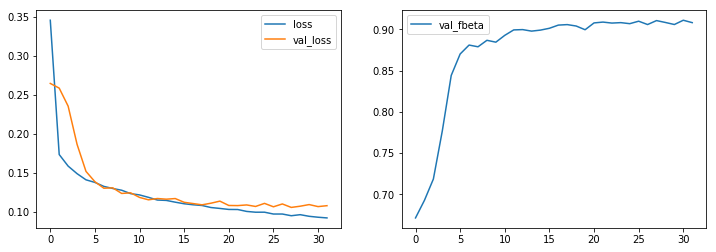

In [63]:
print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
plt.show()